## Plot the rifts on imagery 

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime as dt
%matplotlib inline
import matplotlib 
from netCDF4 import Dataset    


plt.style.use('fivethirtyeight')
# matplotlib.rcParams['ytick.labelsize'] = 'large'
# matplotlib.rcParams['xtick.labelsize'] = 'large'
# matplotlib.rcParams['axes.labelsize'] = 'large'


import numpy as np
import rasterio
from rasterio.plot import show
import pickle

from shapely.ops import nearest_points
from pyproj import Geod
from pyproj import Transformer

import pandas as pd
import geopandas as gpd

from scipy import stats

In [4]:
# (option, useful for Brunt / Halloween)
# Make a bounding box and only look at the points within the box

from shapely.geometry import Point, Polygon

coords = [(-701000,1424000), (-685000,1427500), (-670000,1435000), (-660000,1450000),
         (-655000,1458000),(-685000,1436000),(-703000,1425000)]
poly = Polygon(coords)
box_x,box_y = poly.exterior.xy


## Load the GPS Data

In [5]:
# Load these now so that we can plot the GPS locations on the map
gps = pd.read_csv('datasets/bas_marsh_monthly_halloween.csv')

hh00_x = np.array(gps.PSX[ gps.Site=='HH00' ])
hh00_y = np.array(gps.PSY[ gps.Site=='HH00' ])
tt05_x = np.array(gps.PSX[ gps.Site=='TT05' ])
tt05_y = np.array(gps.PSY[ gps.Site=='TT05' ])
ss00_x = np.array(gps.PSX[ gps.Site=='SS00' ])
ss00_y = np.array(gps.PSY[ gps.Site=='SS00' ])
tt04_x = np.array(gps.PSX[ gps.Site=='TT04' ])
tt04_y = np.array(gps.PSY[ gps.Site=='TT04' ])

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/bas_marsh_monthly_halloween.csv'

## Load ITS_LIVE velocities

In [4]:

# This is a good window for all of brunt-riiser-ekstrom
window_x = [-7.7e5,-4.0e5]
window_y = [1.35e6,2e6]


# d = Dataset('/Users/lipovsky/Downloads/ANT_G0120_0000.nc', 'r')
d = Dataset('datasets/ANT_G0120_0000.nc', 'r')
# print(d.variables['vx'])
itslive_x =d.variables['x']
itslive_x = np.array(itslive_x)

itslive_y =d.variables['y']
itslive_y = np.array(itslive_y)

itslive_vx=d.variables['vx']
itslive_vy=d.variables['vy']
itslive_ocean=d.variables['ocean']

x_slice = itslive_x[ (itslive_x<max(window_x)) & (itslive_x>min(window_x)) ]
y_slice = itslive_y[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) ]
xmesh,ymesh = np.meshgrid(x_slice,y_slice)

vx_slice=itslive_vx[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
vy_slice=itslive_vy[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
ocean_slice=itslive_ocean[ (itslive_y<max(window_y)) & (itslive_y>min(window_y)) , 
            (itslive_x<max(window_x)) & (itslive_x>min(window_x))]
d.close()

# Interpolate.  This will be useful later
from scipy.interpolate import interp2d
vx_interp = interp2d(x_slice, y_slice, vx_slice)
vy_interp = interp2d(x_slice, y_slice, vy_slice)





# Calculate strains

dvx = np.gradient(vx_slice,y_slice,x_slice)
dvy = np.gradient(vx_slice,y_slice,x_slice)

# With this convention:
# dvx[0] is dvx/dy
# dvx[1] is dvx/dx
# dvy[0] is dvy/dy
# dvy[1] is dvy/dx

# Interpolate
vx_x = interp2d(x_slice, y_slice, dvx[1])
vx_y = interp2d(x_slice, y_slice, dvx[0])
vy_x = interp2d(x_slice, y_slice, dvy[1])
vy_y = interp2d(x_slice, y_slice, dvy[0])


<ipython-input-4-7f09d546673b>:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  itslive_x = np.array(itslive_x)
<ipython-input-4-7f09d546673b>:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  itslive_y = np.array(itslive_y)
<ipython-input-4-7f09d546673b>:23: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence th

Text(0, 0.5, 'Polar Stereo Y (m)')

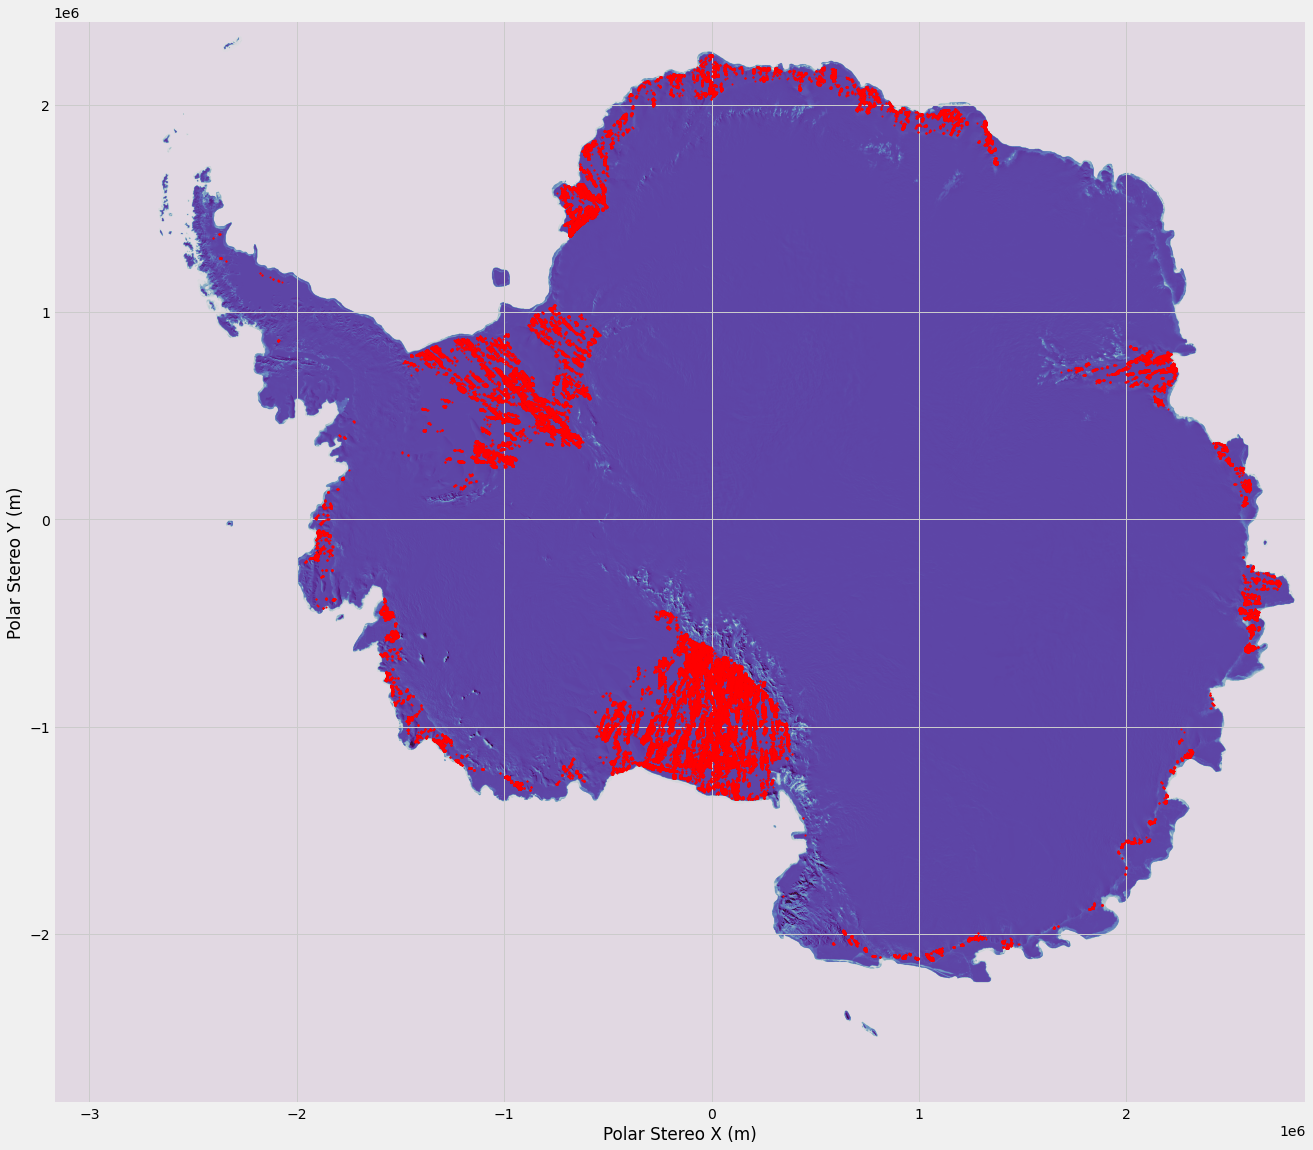

In [8]:
# image_file = 'datasets/riise_2020028_1615_modis_ch02.tif'
image_file = 'datasets/moa750_2014_hp1_v01.tif'

# Plot catalog over imagery
fig2,ax2 = plt.subplots(figsize=(20,20))
sat_data = rasterio.open(image_file)
show(sat_data,cmap="twilight",ax=ax2)


for shelf_name in ['amery','ross','brunt','Fimbul','Ronne','East','Amundsen']:

    # Load the rift observations
    rift_obs_output_file_name = 'output/' + shelf_name + '_rift_obs.pickle'
    with open(rift_obs_output_file_name, 'rb') as handle:
        rift_obs = pickle.load(handle)
    ax2.scatter(rift_obs['x-centroid'] ,rift_obs['y-centroid'] ,s=2,c='r')

    
with open('output/brunt_rift_obs.pickle', 'rb') as handle:
    rift_obs = pickle.load(handle)    

# Make a geopanda

rift_obs = gpd.GeoDataFrame(
    rift_obs, geometry=gpd.points_from_xy(rift_obs['x-centroid'], rift_obs['y-centroid']))



plt.xlabel('Polar Stereo X (m)')
plt.ylabel('Polar Stereo Y (m)')

## Plot just the Halloween crack  against the ITS_LIVE velocities

<ipython-input-9-8af734c2e1a1>:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.mean(hh00_x),np.mean(hh00_y),'sy',MarkerSize=20)
<ipython-input-9-8af734c2e1a1>:21: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.mean(tt05_x),np.mean(tt05_y),'sy',MarkerSize=20)
<ipython-input-9-8af734c2e1a1>:22: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.mean(ss00_x),np.mean(ss00_y),'sy',MarkerSize=20)
<ipython-input-9-8af734c2e1a1>:23: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(np.mean(tt04_x),np.mean(tt04_y),'sy',MarkerSize=20)


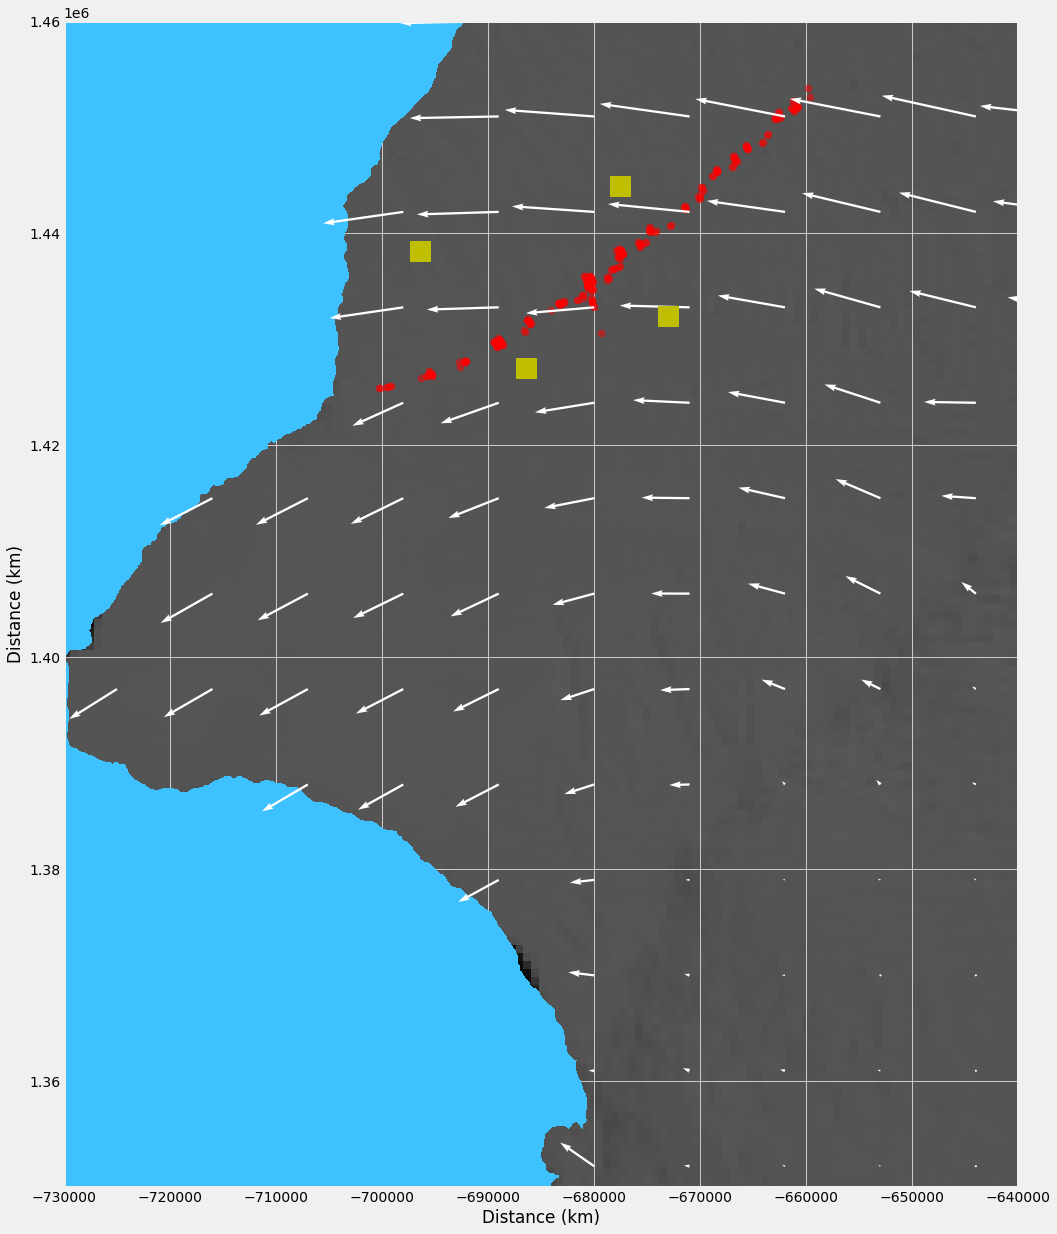

In [9]:
# This is a good window for the Halloween Crack
window_x_halloween = [-7.3e5,-6.4e5]
window_y_halloween = [1.35e6,1.46e6]


fig3,ax3=plt.subplots(figsize=(20,20))

# Subset the data to the Halloween Crack polygon
ho = rift_obs[rift_obs.within(poly)]
# ho = rift_obs

skip=75
plt.scatter(ho['x-centroid'] ,ho['y-centroid'] ,s=50,c='r',alpha=0.5)
plt.contourf(xmesh,ymesh,ocean_slice,cmap=cm.get_cmap('cool',30))
show(sat_data,cmap="gray",ax=ax3,adjust=None)
c = plt.quiver(xmesh[ ::skip, ::skip],
               ymesh[ ::skip, ::skip],
               vx_slice[ ::skip, ::skip], 
               vy_slice[ ::skip, ::skip], scale=9000, color='w')
plt.plot(np.mean(hh00_x),np.mean(hh00_y),'sy',MarkerSize=20)
plt.plot(np.mean(tt05_x),np.mean(tt05_y),'sy',MarkerSize=20)
plt.plot(np.mean(ss00_x),np.mean(ss00_y),'sy',MarkerSize=20)
plt.plot(np.mean(tt04_x),np.mean(tt04_y),'sy',MarkerSize=20)
plt.axis('image')
plt.ylim(window_y_halloween)
plt.xlim(window_x_halloween)
plt.rcParams.update({'font.size': 15})
plt.xlabel('Distance (km)')
plt.ylabel('Distance (km)')
# plt.plot(box_x,box_y)
plt.show()

## Calculate rift widths and axis angles

A big assumption here is that we already have measured the orientation of the rift.  Ideally, this would be done automatically.  For now, I have just written a script to choose the rift axis manually.

In [ ]:

transformer = Transformer.from_crs("EPSG:3031", "EPSG:4326")
geodesic = Geod(ellps='WGS84')

rift_path = pickle.load( open( 'halloween.pickle', "rb" ) )
riftx,rifty = np.array(rift_path.xy)

def estimate_local_rift_orientation(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest > len(x)-2: # We're out of the range of the predefined rift... should probably fix this
        closest = closest-1
    [lat1,long1] = transformer.transform( x[closest] , y[closest] )
    [lat2,long2] = transformer.transform( x[closest+1] ,  y[closest+1] )
    fwd_azimuth,back_azimuth,distance = geodesic.inv(long1, lat1, long2, lat2)
    return fwd_azimuth

def estimate_local_rift_orientation_xy(pt,x,y):
    # Given point(x,y), find the two nearest points in approximate_rift_orientation
    # and then return the slope between these two points
    closest = np.argmin( (pt.x-x)**2 + (pt.y-y)**2 )
    if closest > len(x)-2: # We're out of the range of the predefined rift... should probably fix this
        closest = closest-1
    dx = x[closest+1] - x[closest]
    dy = y[closest+1] - y[closest]
    fwd_azimuth = np.arctan2(dy,dx) * 180/np.pi
#     print('%f, %f, %f'%(dx,dy,fwd_azimuth))
    return fwd_azimuth


# Next step:  estimate actual rift widths for all obs
# This just involves doing a little bit of trigonometry
azimuth = []
azimuth_xy = []
for index, row in ho.iterrows():
    azimuth.append(estimate_local_rift_orientation(row['geometry'],riftx,rifty))
    azimuth_xy.append(estimate_local_rift_orientation_xy(row['geometry'],riftx,rifty))
actual_width = np.abs(np.sin(np.deg2rad(azimuth - ho['azimuth']))) * ho['width']

# These are the angles of the rift axis
ho['rift-angle'] = pd.Series(np.array(azimuth), index=ho.index)
ho['rift-angle-xy'] = pd.Series(np.array(azimuth), index=ho.index)
ho['actual-width'] = pd.Series(np.array(actual_width), index=ho.index)

## Perform advection correction
At each time-step: 1) add new observations, 2) advect old observations, 3) merge observations if they are close enough


In [ ]:
# This version uses pandas in all its glory

time_vector = np.sort(np.unique(ho.time))
time_diff = np.diff(time_vector)
list_of_state_vectors = []
min_seperation_threshold = 0
seperation_list = []
state_vector = pd.DataFrame({'x':np.array([]),'y':np.array([]),'w':np.array([]),
                             't':np.array([]),'a':np.array([])})

for t,i in zip(time_vector,np.arange(len(time_vector))):
    new_obs = ho[ho['time']==t]
    if i>0:
        dt = time_diff[i-1].total_seconds()/86400/365.25 # time step in years
    else:
        dt = np.inf
    print('%i. Found %i new observations at time %s with dt=%s'%(i,len(new_obs),t,dt))
    

    
    # Update the locations of any previous measurements
    if t > min(time_vector):
        
        vx_new = vx_interp(state_vector['x'],state_vector['y']).diagonal()
        vy_new = vy_interp(state_vector['x'],state_vector['y']).diagonal()
        
        # Calculate strain rates
        e11 = vx_x(state_vector['x'],state_vector['y']).diagonal()
        e12 = ( vx_y(state_vector['x'],state_vector['y']).diagonal() 
              + vy_x(state_vector['x'],state_vector['y']).diagonal() ) / 2
        e22 = vy_y(state_vector['x'],state_vector['y']).diagonal()
        
        # Direction cosines of the rift
        dx1 = np.cos(state_vector['a'] * np.pi / 180 + np.pi/2)
        dx2 = np.sin(state_vector['a']* np.pi / 180 + np.pi/2)
        
        # Total stretch on the rift
        dw = e11 * dx1 * dx1 + e12 * dx1 * dx2 + e12 * dx2 * dx1 + e22 * dx2 * dx2
        
        state_vector['x'] = state_vector['x'] + dt * vx_new
        state_vector['y'] = state_vector['y'] + dt * vy_new
        state_vector['w'] = state_vector['w']* (1 + dt * dw )
    
    
    # Add new observations
    add_this = new_obs.rename(columns={"x-centroid": "x", "y-centroid": "y", "width": "w", 
                                       "time": "t", "rift-angle-xy": "a"})
    state_vector = state_vector.append( add_this[["x", "y", "w", "t","a"]] )
    list_of_state_vectors.append(pd.DataFrame(state_vector))

In [ ]:
fig7,ax7 = plt.subplots(figsize=(10,10))
color=iter(cm.viridis(np.linspace(0,1,len(list_of_state_vectors))))
for item,t in zip(reversed(list_of_state_vectors),reversed(time_vector)):
    c=next(color)
    plt.scatter(item['x']/1e3,item['y']/1e3,color=c, label='%i-%i-%i'%(t.year,t.month,t.day))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid()
plt.xlim((-694,-691))
plt.ylim((1426,1429))
plt.show()

In [ ]:
fig9,ax9 = plt.subplots(7, 6,sharex='all', sharey='all',figsize=(15,15))
# fig9,ax9 = plt.subplots(7, 6,figsize=(15,15))

for item,t,i in zip(list_of_state_vectors,time_vector,np.arange(len(list_of_state_vectors))):
    plt.subplot(6,7,1+i)
    plt.scatter(item['x']/1e3,item['y']/1e3,alpha=0.1)
    plt.title('%d %d'%(t.year,t.month))
plt.show()

In [ ]:
latest = list_of_state_vectors[-1]
times = latest['t'].apply(lambda x: (x- latest.iloc[0]['t']).days).values
times_h = ho['time'].apply(lambda x: (x- latest.iloc[0]['t']).days).values

In [ ]:
# Plot a snapshot
plt.subplots(2,1,figsize=(15,15))
ax=plt.subplot(2,1,1)
c=ax.scatter(ho['x-centroid'],ho['y-centroid'],c=times_h,cmap='bone',alpha=0.5,edgecolors='k')
ax.set_title('Before correction for advection')

ax=plt.subplot(2,1,2)
c=ax.scatter(latest['x'],latest['y'],c=times,cmap='bone',alpha=0.5,edgecolors='k')
ax.set_title('After correction for advection')
plt.show()

## Simple Model of Rift Opening

In [ ]:
xmin = latest.loc[latest['x'].idxmin()]['x']
ymin = latest.loc[latest['x'].idxmin()]['y']

dist = np.sqrt( (latest['x'].to_numpy()-xmin)**2 + (latest['y'].to_numpy()-ymin)**2 )

rift_len = 48
xx = np.arange(0,rift_len,0.01)

tmax = max(times)
rate = 330 / 365
wmax = rate * tmax

wmax2 = 1000
rate2 = wmax2/tmax
r = np.sqrt(rift_len**2 - xx**2)





fig12 = plt.subplots(2,1,figsize=(10,18),sharex=True,sharey=True)


for i in (1,2,3):
    ax=plt.subplot(3,1,i)
    n=i
    ax.plot(xx,wmax* (r/rift_len)**n,'-',label='Just stretching')
    ax.plot(xx,wmax2* (r/rift_len)**n,'-',label='Stretch + Erosion')
    ax.legend()

    c=ax.scatter(dist/1e3,latest['w'],c=times,cmap='bone',label=latest['t'],\
                 alpha=0.5,edgecolors='k')
    cbar=plt.colorbar(c)

    cbar.set_label('Days since first observation')
    ax.set_xlabel('Distance along rift (km)')
    ax.set_ylabel('Rift width (m)')
    ax.set_title('Rift width model (flow law n=%d)'%n)



plt.show()

print('Stretching: %f m over %f days or %f m/y'%(wmax,tmax,rate * 365))
print('Erosion + stretching: %f m over %f days or %f m/y'%(wmax2,tmax,rate2 * 365))
print('Erosion is %f %%'%(100*(wmax2-wmax)/wmax2))

## Calculate the average GPS opening

In [ ]:
t = gps.YYYY.values + gps.MM.values / 12
hh00_vx = stats.linregress(t[0:len(hh00_x)], hh00_x).slope
hh00_vy = stats.linregress(t[0:len(hh00_y)], hh00_y).slope
tt05_vx = stats.linregress(t[0:len(tt05_x)], tt05_x).slope
tt05_vy = stats.linregress(t[0:len(tt05_y)], tt05_y).slope
ss00_vx = stats.linregress(t[0:len(ss00_x)], ss00_x).slope
ss00_vy = stats.linregress(t[0:len(ss00_y)], ss00_y).slope
tt04_vx = stats.linregress(t[0:len(tt04_x)], tt04_x).slope
tt04_vy = stats.linregress(t[0:len(tt04_y)], tt04_y).slope

#What is the average strike of the rift?
res = stats.linregress(latest['x'], latest['y'])
theta = - np.arctan(res.slope) 
rot = np.array([[np.cos(theta), -np.sin(theta)],\
                [np.sin(theta), np.cos(theta)]])

hh00_v = np.array([hh00_vx, hh00_vy])
tt05_v = np.array([tt05_vx, tt05_vy])
ss00_v = np.array([ss00_vx, ss00_vy])
tt04_v = np.array([tt04_vx, tt04_vy])

#
# Rotate into rift-coordinates
#

v1 = np.dot(rot, hh00_v)
v2 = np.dot(rot, tt05_v)
v3 = np.dot(rot, ss00_v)
v4 = np.dot(rot, tt04_v)

relative_motion = v1-v2


print('Relative motion with just hh00 and tt05:')
print('   Rift Shearing: %f m/a '%relative_motion[0])
print('   Rift Opening: %f m/a '%relative_motion[1])
print(' ')
relative_motion = (v1+v3)/2-(v2+v4)/2
print('Relative motion with hh00, ss00, tt04, and tt05:')
print('   Rift Shearing: %f m/a '%relative_motion[0])
print('   Rift Opening: %f m/a '%relative_motion[1])

## Use GPS to calculate the time-dependent extension and shearing

In [ ]:
# What do the GPS data look like?

t = gps.YYYY.values + gps.MM.values / 12
hh00_u = np.array(gps.PSU[ gps.Site=='HH00' ])
hh00_v = np.array(gps.PSV[ gps.Site=='HH00' ])
tt05_u = np.array(gps.PSU[ gps.Site=='TT05' ])
tt05_v = np.array(gps.PSV[ gps.Site=='TT05' ])
ss00_u = np.array(gps.PSU[ gps.Site=='SS00' ])
ss00_v = np.array(gps.PSV[ gps.Site=='SS00' ])
tt04_u = np.array(gps.PSU[ gps.Site=='TT04' ])
tt04_v = np.array(gps.PSV[ gps.Site=='TT04' ])

#
# Rotate into rift-coordinates
#


v1 = np.dot(rot, np.array([hh00_u,hh00_v])[:,0:30])
v2 = np.dot(rot, np.array([tt05_u,tt05_v])[:,0:30])
v3 = np.dot(rot, np.array([ss00_u,ss00_v])[:,0:30])
v4 = np.dot(rot, np.array([tt04_u,tt04_v])[:,0:30])

# relative_motion = (v1+v3)/2-(v2+v4)/2
relative_motion = (v1-v2)*365

plt.subplots(figsize=(15,5))
plt.plot(t[0:30],relative_motion[1,:],'o',label='Extension Rate')
plt.plot(t[0:30],-relative_motion[0,:],'o',label='Shearing Rate')
plt.legend()
plt.ylabel('m/a')

plt.show()

print(np.mean(relative_motion[0,:]))
print(np.mean(relative_motion[1,:]))

## Can we observe this the variability in stretching rate in the ICESat-2 data?

In [ ]:
plt.subplots(figsize=(15,5))
plt.scatter(latest['t'],latest['w'],c=dist)

In [ ]:
type(latest)

In [ ]:
ho